In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
!pip install iterative-stratification

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
from albumentations import *
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import time
from IPython.display import clear_output
from scipy.ndimage.filters import gaussian_filter1d
from tqdm.notebook import tqdm, tnrange
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataset import random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
!cp /content/drive/"My Drive"/mydata/clean_training_data.csv /content/
!cp /content/drive/"My Drive"/frames_raw.zip /content/
!unzip frames_raw.zip

In [ ]:
df = pd.read_csv("clean_training_data.csv")
a_pop_upper_limit = 250

look_for_tag = "ceh-"
avoid_tags = ["20080819_ceh-41_14_L1", 
              "20081108_ceh-36_b13_L1"]

df = df[df["A"] <= a_pop_upper_limit]
df = df[df["filenames"].str.contains(look_for_tag) == True]

for tag in avoid_tags:
    df = df[df["filenames"].str.contains(tag) == False]


print(df.info())

In [7]:
def preprocess_df_and_save_as_csv(df, filename="preprocessed_data.csv"):
  data =  df[["A", "E", "M", "P", "C", "D", "Z"]].values
  #scaler = MinMaxScaler()
  print("Scaler = ", scaler.fit(data))
  print("Minimum values of each column = ", scaler.data_min_)
  print("Maximum values of each column = ", scaler.data_max_)

  joblib.dump(scaler, 'scaler.gz')
  new_data = scaler.transform(data)
  print(new_data.shape)
  new_df = pd.DataFrame(new_data)
  new_df["filenames"] = df["filenames"].values
  new_df.columns = ["A", "E", "M", "P", "C", "D", "Z", "filenames"]
  final_df = new_df 
  final_df.to_csv(filename, index = False)
  final_df.tail(5)
  return(final_df)

In [ ]:
scaler = MinMaxScaler()
preprocess_df_and_save_as_csv(df=df, 
                              filename="scaled_data.csv")

In [ ]:
def create_folds(df, path=""):
  df = df.copy()
  df.loc[:,"kfold"] = -1

  #df = df.sample(frac=1).reset_index(drop=True)

  targets = df.drop("filenames", axis=1).values

  NFOLDS = 10
  mskf = MultilabelStratifiedKFold(n_splits = NFOLDS)
  for fold, (trn, val) in enumerate(mskf.split(X=df, y = targets)):
      df.loc[val, "kfold"] = fold
      
  df.to_csv(path, index=False)

create_folds(df=pd.read_csv("scaled_data.csv"), path="./train_folds.csv")

In [10]:
class ImageDataset(Dataset):   
    def __init__(self, df, preprocess_image= False, augmentation =None, transform = None, RGB = False):
        
        self.df = df
        self.image_paths = self.df.filenames.values
        self.labels = self.df[["A", "E", "M", "P", "C", "D", "Z"]].values
        self.transform = transform
        self.augmentation = augmentation
        self.preprocess = preprocess_image
        self.RGB = RGB

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        
        if self.RGB == False:
            image = cv2.imread(path, 0)
        else:
            image = cv2.imread(path)

        if self.preprocess == True:
            image = preprocess_image_np(image)

        if self.augmentation is not None:
            img  = self.augmentation(image = image)
            image = img["image"]
            
        label = torch.Tensor(self.labels[idx]).float()

        return {
        "x": self.transform(image),
        "y": label
        }

    def __len__(self):
        return len(self.image_paths)

In [11]:
train_csv = pd.read_csv("train_folds.csv")
full_dataset = ImageDataset(train_csv,
                         augmentation = Compose([ 
                                                VerticalFlip(p=0.5),
                                                HorizontalFlip(p=0.5),
                                                RandomContrast(limit=0.9, p=0.5),
                                                Transpose(p=0.5),
                                                 ElasticTransform(p=0.5, alpha=30, sigma=120 * 0.05, alpha_affine=120 * 0.03)

                                            ]),
                        transform = transforms.Compose([    
                                                        transforms.ToPILImage(),
                                                        transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                        torchvision.transforms.RandomAffine(degrees = 10, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                        ToTensor(),
                                                        transforms.Normalize(0.5, 0.5, 0.5)
                                                        ]),
                        RGB = True ## set to true for ResNet
                            )

In [ ]:
train_size = int(0.9* len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=63, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 7, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

In [43]:
def inverse_transform_prediction(output):
  lab = output.reshape(1,-1) ## convert to 2d np array
  lab = scaler.inverse_transform(lab).flatten() ## back to original domain
  lab = [int(i) for i in lab] ## convert to int 
  return lab

def show_preds(model, batch):
  fig, ax = plt.subplots(3,3, figsize = (15,15))
  images , labels = batch['x'], batch['y']
  model.eval()
  preds = model(images.cuda()).cpu().detach()
  for i in range (9):
    ax.flat[i].imshow(images[i][0])
    text = "label = "+ str(inverse_transform_prediction(labels[i]))  + "  pred = " + str(inverse_transform_prediction(preds[i]))
    ax.flat[i].set_xlabel(text , fontsize= 10)

def show_batch(batch):
  fig, ax = plt.subplots(4,4, figsize = (19,19))
  images , labels = batch['x'], batch['y']
  for i in range (16):
      ax.flat[i].imshow(images[i][0], cmap='gray')
      lab = inverse_transform_prediction(labels[i])
      ax.flat[i].set_xlabel("label = "+ str(lab), fontsize= 15)

In [ ]:
batch = next(iter(train_loader))
show_batch(batch)

In [15]:
class Engine:
      def __init__(self, model, optimizer, device, scheduler):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler

      @staticmethod
      def loss_fn(targets, outputs):
        return nn.MSELoss() (outputs, targets)

      def train(self, data_loader):
        self.model.train()
        final_loss=0
        for data in tqdm(data_loader):
            self.optimizer.zero_grad()
            inputs = data["x"].to(self.device)
            targets = data["y"].to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fn(targets, outputs)
            loss.backward()
            
            self.optimizer.step()
            
            final_loss += loss.item()
        self.scheduler.step(1.)
        return(final_loss / len(data_loader))


      def evaluate(self, data_loader):
        self.model.train()
        final_loss=0
        for data in data_loader:
            #self.optimizer.zero_grad()
            inputs = data["x"].to(self.device)
            targets = data["y"].to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fn(targets, outputs)
            #loss.backward()
            #self.optimizer.step()
            final_loss += loss.item()
        return(final_loss / len(data_loader))

In [16]:
def run_training(fold, batch_size, lr, save_model=True, num_epochs = 69):

    val_fold=train_csv[train_csv['kfold'] == fold]
    train_fold=train_csv[train_csv['kfold'] != fold]
    
    
    train_dataset = ImageDataset(train_fold,
                         augmentation = Compose([ 
                                                VerticalFlip(p=0.5),
                                                HorizontalFlip(p=0.5),
                                                RandomContrast(limit=0.9, p=0.5),
                                                Transpose(p=0.5),
                                                 ElasticTransform(p=0.5, alpha=30, sigma=120 * 0.05, alpha_affine=120 * 0.03)

                                            ]),
                        transform = transforms.Compose([    
                                                        transforms.ToPILImage(),
                                                        transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                        torchvision.transforms.RandomAffine(degrees = 10, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                        ToTensor(),
                                                        transforms.Normalize(0.5, 0.5, 0.5)
                                                        ]),
                        RGB = True ## set to true for ResNet
                            )
    valid_dataset = ImageDataset(val_fold,
                         augmentation = Compose([ 
                                                VerticalFlip(p=0.5),
                                                HorizontalFlip(p=0.5),
                                                RandomContrast(limit=0.9, p=0.5),
                                                Transpose(p=0.5),
                                                 ElasticTransform(p=0.5, alpha=30, sigma=120 * 0.05, alpha_affine=120 * 0.03)

                                            ]),
                        transform = transforms.Compose([    
                                                        transforms.ToPILImage(),
                                                        transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                        torchvision.transforms.RandomAffine(degrees = 10, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                        ToTensor(),
                                                        transforms.Normalize(0.5, 0.5, 0.5)
                                                        ]),
                        RGB = True ## set to true for ResNet
                            )
    
    train_loader = torch.utils.data.DataLoader(
                    train_dataset
                    ,batch_size=batch_size
                    ,shuffle=True
                    #,num_workers = 2
                )

    val_loader = torch.utils.data.DataLoader(
                    valid_dataset
                    ,batch_size=7
                    ,shuffle=True
                )

    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 7)
    model = model_ft.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr = 0.001) 

    
    scheduler = ReduceLROnPlateau(optimizer, 
                                  mode='min', 
                                  factor=0.5, 
                                  patience=2, 
                                  verbose=False, 
                                  threshold=0.0001, 
                                  threshold_mode='rel', 
                                  cooldown=0, 
                                  min_lr=0, 
                                  eps=1e-08)
    criterion = nn.CrossEntropyLoss() 
    eng = Engine(model, optimizer, device='cuda', scheduler = scheduler)
    
    best_loss = 999
    early_stop_iter = 10
    early_stop_count=0

    for epoch in range(num_epochs):
        train_loss = eng.train(train_loader)
        valid_loss = eng.evaluate(val_loader)
        print("train_loss:", train_loss, "val_loss:", valid_loss)
        if valid_loss<best_loss:
            best_loss = valid_loss
            if save_model:
                torch.save(model.state_dict(), "model_"+str(fold)+".pth")
        else:
            early_stop_count +=1
            
        if early_stop_count>early_stop_iter:
            break
    # save_path = "./pre_clean_l1_estimate_lineage_population_resnet18.pt"
    # torch.save(model.state_dict(), save_path)
    return(best_loss)

In [ ]:
loss_  = run_training(
        fold=0,
        batch_size = 63,
        lr =0.001,
        num_epochs = 3
    )

#test on 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
best_losses = []
for fold in range(10):
    best_losses.append(run_training(
        fold=fold,
        batch_size = 63,
        lr =0.001,
        num_epochs = 8
    ))

In [ ]:
plt.plot(best_losses)

In [22]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)
model = model_ft.to(device)
model.load_state_dict(torch.load( "./model_" +"9"+ ".pth"))

<All keys matched successfully>

In [23]:
all_models = [model for i in range (10)]
for i in range (len(all_models)):
    
    name = "./model_" + str(i) + ".pth"
    all_models[i].load_state_dict(torch.load(name))
    all_models[i].to(device)
    print("Loaded: ", name)

Loaded:  ./model_0.pth
Loaded:  ./model_1.pth
Loaded:  ./model_2.pth
Loaded:  ./model_3.pth
Loaded:  ./model_4.pth
Loaded:  ./model_5.pth
Loaded:  ./model_6.pth
Loaded:  ./model_7.pth
Loaded:  ./model_8.pth
Loaded:  ./model_9.pth


In [34]:
def pred_jury(images, list_of_models):
  for m in list_of_models:
    m.eval()
  
  list_of_preds=[]
  #print("zeros",list_of_preds)
  for i in range(len(list_of_models)):
    pred=list_of_models[i](images.cuda()).cpu().detach()
    list_of_preds.append(pred)
  
  list_of_preds=np.concatenate(list_of_preds, axis=0)
  #print("LOP",list_of_preds)
  mean_ = np.mean(list_of_preds, axis=0)  #giving out single mean for multiple imeages
  #print("MEAN MEAN",mean_)
  #print(mean)
  return(mean_)

In [35]:
def show_preds_from_jury(jury, batch, list_of_models):
  fig, ax = plt.subplots(3,3, figsize = (15,15))
  images , labels = batch['x'], batch['y']
  #print(inverse_transform_prediction(labels[0]))
  #print("labels",labels[0])
  #model.eval()
  preds = pred_jury(images.to(device), list_of_models)#.cpu().detach()
  # print("Labels size",labels)
  # print("preds size", preds)
  # print(images.size())
  for i in range (9):
    #ax.flat[i].imshow(np.transpose(images[i][0], (0,1,2)))
    ax.flat[i].imshow(images[i][0])
    text = "label = "+ str(inverse_transform_prediction(labels[i])) + "  pred = " + str(inverse_transform_prediction(preds[i]))
    ax.flat[i].set_xlabel(text , fontsize= 10)

In [36]:
def pred_one_image_jury(image, list_of_models):
  preds = pred_jury(image.to(device), list_of_models)

  return(inverse_transform_prediction(preds))

In [40]:
val_loader = DataLoader(dataset=test_dataset, batch_size= 1, shuffle = True)

for i in val_loader:
  print(pred_one_image_jury(i['x'], all_models))
  break

[99, 6, 22, 0, 12, 3, 1]


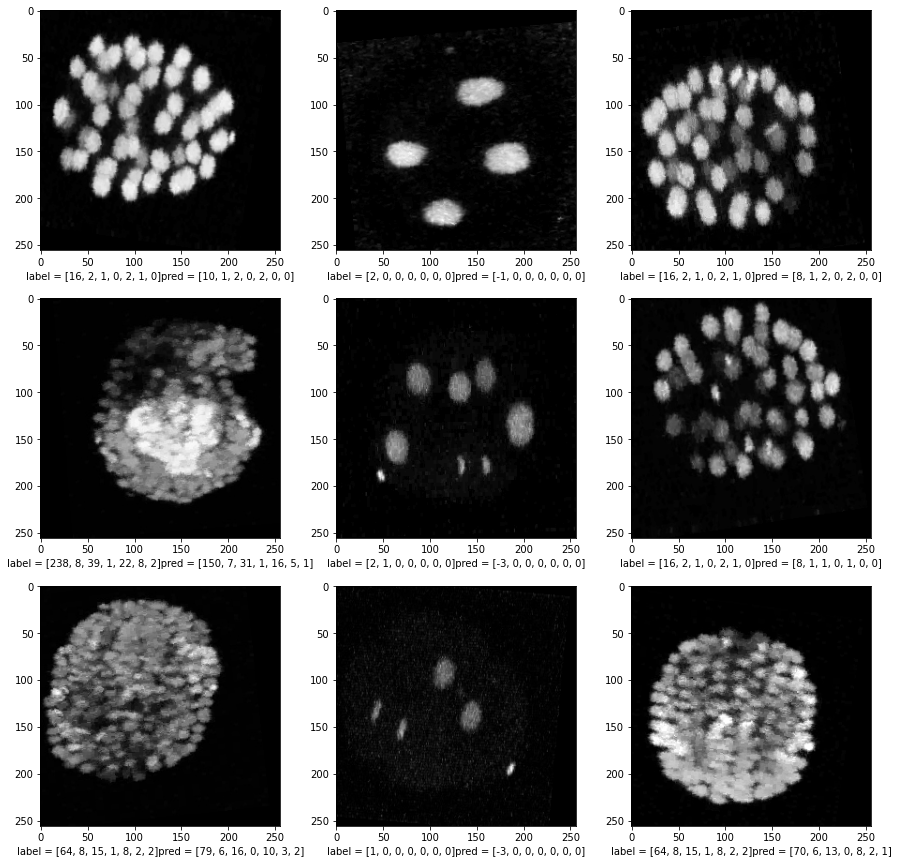

In [62]:
fig, ax = plt.subplots(3,3, figsize = (15,15))
images , labels = batch['x'], batch['y']

for i in range (9):
  batch = next(iter(val_loader))
  image, label=batch['x'],batch['y']
  ax.flat[i].imshow(image.squeeze()[0], cmap='gray')
  inv_pred = pred_one_image_jury(image, all_models)
  text = "label = "+ str(inverse_transform_prediction(label)) + "pred = " +str(inv_pred)
  ax.flat[i].set_xlabel(text)

In [50]:
#plot preds on a single video
df_test = pd.read_csv("/content/scaled_data.csv")
look_for_tag = "20071217_ceh-432x3"

a_pop_upper_limit = 250

df_test = df_test[df_test["A"] <= a_pop_upper_limit]

df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)].head(360)
df_single_cell.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 2707 to 3066
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   A          360 non-null    float64
 1   E          360 non-null    float64
 2   M          360 non-null    float64
 3   P          360 non-null    float64
 4   C          360 non-null    float64
 5   D          360 non-null    float64
 6   Z          360 non-null    float64
 7   filenames  360 non-null    object 
dtypes: float64(7), object(1)
memory usage: 25.3+ KB


In [51]:
data = scaler.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)
real_time_plots = []
for i in range(len(df_single_cell.columns[1:])):
    real_time_plots.append(data[:,i])

In [53]:
mini_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                     transforms.Resize((256,256), interpolation = Image.NEAREST),
                                     transforms.ToTensor(),
                                     transforms.Normalize(0.5, 0.5, 0.5)
])

In [54]:
preds = []
filenames = df_single_cell.filenames.values
for i in range (len(filenames)):

    image = cv2.imread(filenames[i])
   
    tensor = mini_transform(image).unsqueeze(0).cuda()
    pred = model(tensor).cpu().detach().numpy().flatten()
    preds.append(pred)
    
preds = scaler.inverse_transform(np.array(preds)).astype(np.uint8)

In [56]:
generated_time_plots = []
for i in range(len(df_single_cell.columns[1:])):
    generated_time_plots.append(preds[:,i])


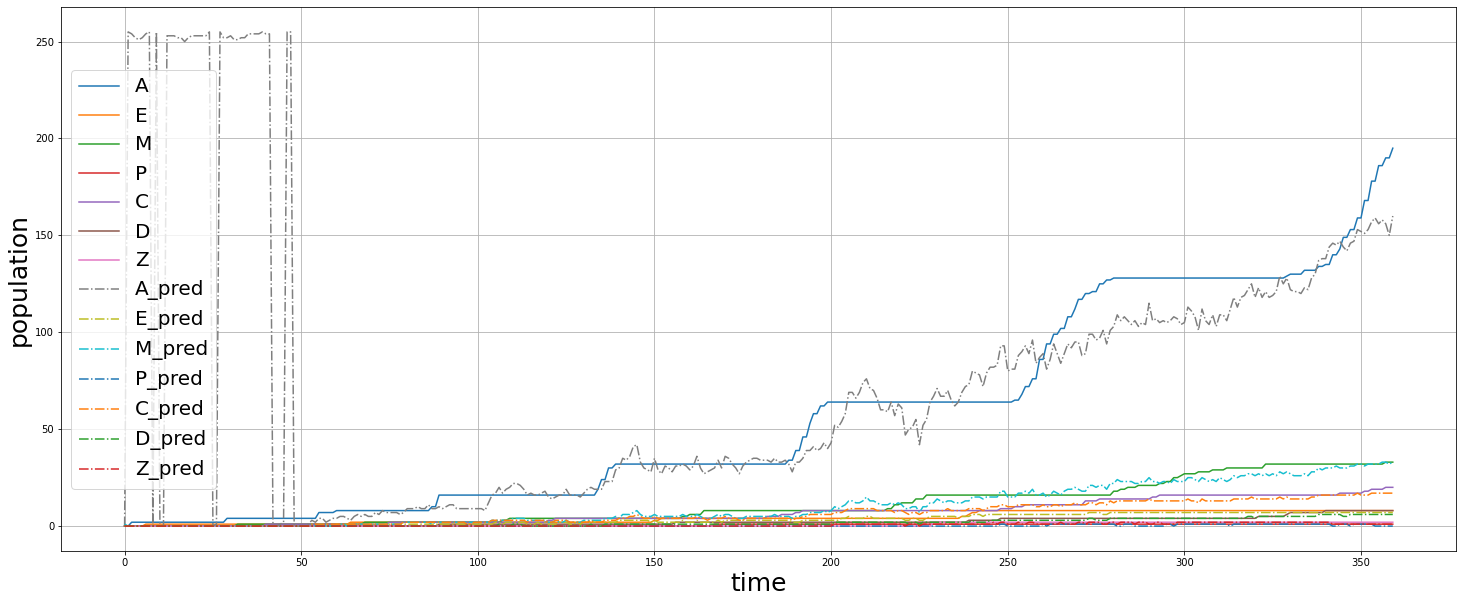

In [66]:
plt.rcParams['figure.figsize'] =25, 10

for i in range(len(real_time_plots)):
    plt.plot(real_time_plots[i], label = df_single_cell.columns[:-1][i] )


for i in range(len(generated_time_plots)):
    plt.plot(generated_time_plots[i], label = df_single_cell.columns[:-1][i] + "_pred", linestyle = "-." )

plt.xlabel("time", fontsize = 25)
plt.ylabel("population", fontsize = 25)
plt.legend(fontsize = 20)
plt.grid()